In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import collections
import itertools
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as spio
import tensorflow as tf

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from six.moves import urllib

In [4]:
URL_TRAIN_PATH = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
URL_TEST_PATH = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'

DOWNLOADED_FILENAME_TRAIN = 'housenumbers_training.mat'
DOWNLOADED_FILENAME_TEST = 'housenumbers_test.mat'

def download_data():
  if not os.path.exists(DOWNLOADED_FILENAME_TRAIN):
    filename, _ = urllib.request.urlretrieve(URL_TRAIN_PATH, DOWNLOADED_FILENAME_TRAIN)
  if not os.path.exists(DOWNLOADED_FILENAME_TEST):
    filename, _ = urllib.request.urlretrieve(URL_TEST_PATH, DOWNLOADED_FILENAME_TEST)

In [5]:
download_data()

In [6]:
train_mat = spio.loadmat(DOWNLOADED_FILENAME_TRAIN, squeeze_me=True)
test_mat = spio.loadmat(DOWNLOADED_FILENAME_TEST, squeeze_me=True)

In [7]:
type(train_mat)

dict

In [8]:
train_mat.keys()

['y', 'X', '__version__', '__header__', '__globals__']

In [9]:
x_train = train_mat['X']
y_train = train_mat['y']

x_test = test_mat['X']
y_test = test_mat['y']

In [10]:
x_train.shape

(32, 32, 3, 73257)

In [11]:
x_train = np.transpose(x_train, (3,0,1,2))
x_test = np.transpose(x_test, (3,0,1,2))

In [12]:
x_train = x_train[:10000]
x_test = x_test[:10000]

In [13]:
x_train[0].shape

(32, 32, 3)

In [14]:
def display_digit(digit):
  plt.imshow(digit, interpolation='nearest')

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


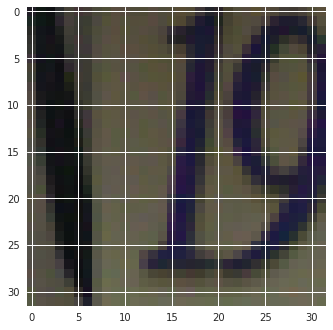

In [15]:
display_digit(x_train[0])

In [16]:
heigth = 32
width = 32
channels = 3

n_inputs = heigth * width

In [17]:
conv1_feature_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = 'SAME'

In [18]:
conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = 'SAME'

In [19]:
pool3_feature_maps = conv2_feature_maps

In [20]:
n_fullyconn1 = 64
n_outputs = 11

In [21]:
tf.reset_default_graph()

In [22]:
X = tf.placeholder(tf.float32, shape=[None, heigth, width, channels], name='X')

In [23]:
y = tf.placeholder(tf.int32, shape=[None], name='y')

In [24]:
conv1 = tf.layers.conv2d(X, filters=conv1_feature_maps, kernel_size=conv1_kernel_size, strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu, name='conv1')

In [25]:
conv1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(32)])

In [26]:
conv2 = tf.layers.conv2d(X, filters=conv2_feature_maps, kernel_size=conv2_kernel_size, strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu, name='conv2')

In [27]:
conv2.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(64)])

In [28]:
pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1],padding='VALID')

In [29]:
pool3_flat = tf.reshape(pool3, shape=[-1, pool3_feature_maps*8*8])

In [30]:
fullyconn1 = tf.layers.dense(pool3_flat, n_fullyconn1, activation=tf.nn.relu, name='fc1')

In [31]:
logits = tf.layers.dense(fullyconn1, n_outputs, name='output')

In [32]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)

In [33]:
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

In [34]:
correct = tf.nn.in_top_k(logits, y, 1)

In [35]:
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [36]:
init = tf.global_variables_initializer()

In [37]:
current_iteration = 0

def get_next_batch(batch_size):
  global current_iteration
  start_index = (current_iteration * batch_size) % len(y_train)
  end_index = start_index + batch_size
  
  x_batch = x_train[start_index: end_index]
  y_batch = y_train[start_index: end_index]
  
  current_iteration = current_iteration + 1
  
  return x_batch, y_batch

In [38]:
n_epochs = 10
batch_size = 100

In [39]:
with tf.Session() as sess:
  init.run()
  num_examples = len(y_train)
  for epoch in range(n_epochs):
    for iteration in range(num_examples//batch_size):
      X_batch, y_batch = get_next_batch(batch_size)
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    acc_train = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
    acc_test = accuracy.eval(feed_dict={X:x_test, y:y_test})
    print(epoch, 'train accuracy:', acc_train, 'test accuracy:', acc_test)

InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [0,11] and labels shape [100]
	 [[Node: SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](output/BiasAdd, _arg_y_0_1)]]

Caused by op u'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/usr/local/envs/py2env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/envs/py2env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-1655b29e8af6>", line 1, in <module>
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1964, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 4804, in _sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/local/envs/py2env/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must have the same first dimension, got logits shape [0,11] and labels shape [100]
	 [[Node: SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](output/BiasAdd, _arg_y_0_1)]]
